# 택시 데이터 분석 및 예측

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols

#### - vendor_id: 택시 공급업체의 ID가 기능입니다.
#### - rate_code: 택시 이동의 요금 유형이 기능입니다.
#### - passenger_count: 이동하는 승객 수가 기능입니다.
#### - trip_time_in_secs: 이동에 걸린 시간입니다. 이동을 완료하기 전에 이동 요금을 예측하려고 합니다. 
#### 해당 시간에는 이동이 얼마나 길지 알지 못합니다. 
#### 따라서 이동 시간은 기능이 아니며 모델에서 이 열을 제외합니다.
#### - trip_distance: 이동 거리가 기능입니다.
#### - payment_type: 결제 방법(현금 또는 신용 카드)이 기능입니다.
#### - fare_amount: 지급한 총 택시 요금이 레이블입니다.

In [2]:
data = pd.read_csv("C:/Users/Hyungjink/Documents/taxi-data/taxi-fare-train.csv")

In [3]:
df = data.copy()
df

,vendor_id,rate_code,passenger_count,trip_time_in_secs,trip_distance,payment_type,fare_amount
0,CMT,1,1,1271,3.80,CRD,17.5
1,CMT,1,1,474,1.50,CRD,8.0
2,CMT,1,1,637,1.40,CRD,8.5
3,CMT,1,1,181,0.60,CSH,4.5
4,CMT,1,1,661,1.10,CRD,8.5
...,...,...,...,...,...,...,...
1048570,VTS,1,1,2100,17.51,CRD,50.5
1048571,VTS,1,1,900,5.94,CSH,19.0
1048572,VTS,1,1,840,2.10,CSH,10.5
1048573,VTS,1,1,2340,4.70,CRD,24.5


### 결측값 확인

In [4]:
df.isnull().sum()

vendor_id            0
rate_code            0
passenger_count      0
trip_time_in_secs    0
trip_distance        0
payment_type         0
fare_amount          0
dtype: int64

### 산포도 그래프

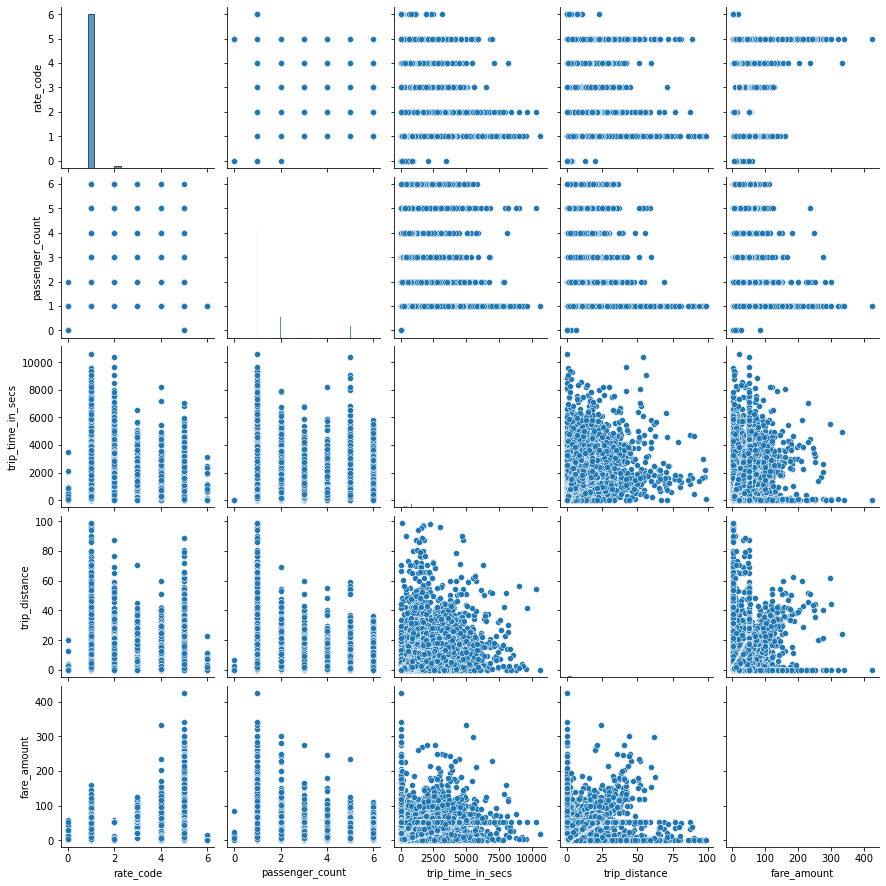

In [5]:
sns.pairplot(df)

#### => 그래프로 봤을 때 이동시간, 이동거리가 요금과 크게 상관성이 없어보인다.

## 이상치를 제거

#### 제거전의 boxplot

<AxesSubplot:>

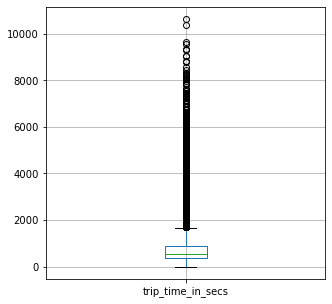

In [206]:
df.boxplot(column = 'trip_time_in_secs')

<AxesSubplot:>

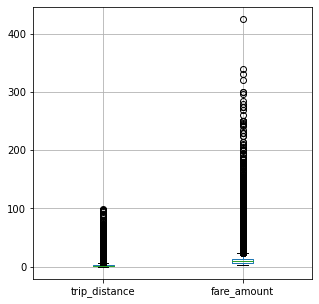

In [207]:
df.boxplot(column = ['trip_distance', 'fare_amount'])

### iqr로 이상치 제거

In [6]:
d_q3 = df['trip_distance'].quantile(0.75)
d_q1 = df['trip_distance'].quantile(0.25)

d_iqr = d_q3 - d_q1

t_q3 = df['trip_time_in_secs'].quantile(0.75)
t_q1 = df['trip_time_in_secs'].quantile(0.25)

t_iqr = t_q3 - t_q1

In [7]:
print(d_q3, d_q1, d_iqr)
print(t_q3, t_q1, t_iqr)

3.09 1.0 2.09
887.0 360.0 527.0


In [8]:
import numpy as np

def defect_outliers(df, features):
    outlier_indices = []
    for col in features:
        q1 = np.percentile(df[col], 25)
        q3 = np.percentile(df[col], 75)
        
        iqr = q3 - q1
        outlier_step = 1.5 * iqr
        
        outlier_list_col = df[(df[col] < q1 - outlier_step) | (df[col] > q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = set(outlier_indices)
    outlier_indices = list(outlier_indices)
    return outlier_indices

### trip_distance, trip_time_in_secs, fare_amount 제거 => new_df

In [9]:
outliers_to_drop = defect_outliers(df, ['trip_distance', 'trip_time_in_secs', 'fare_amount'])
outliers_to_drop.sort()
# outliers_to_drop

In [10]:
new_df = df.drop(outliers_to_drop, axis = 0).reset_index(drop = True)
new_df

,vendor_id,rate_code,passenger_count,trip_time_in_secs,trip_distance,payment_type,fare_amount
0,CMT,1,1,1271,3.80,CRD,17.5
1,CMT,1,1,474,1.50,CRD,8.0
2,CMT,1,1,637,1.40,CRD,8.5
3,CMT,1,1,181,0.60,CSH,4.5
4,CMT,1,1,661,1.10,CRD,8.5
...,...,...,...,...,...,...,...
938967,VTS,1,1,780,2.96,CRD,11.5
938968,VTS,1,1,300,0.97,CSH,5.5
938969,VTS,3,6,0,0.00,CSH,20.0
938970,VTS,1,1,900,5.94,CSH,19.0


### trip_time_in_secs가 0인 값
### trip_distance가 0인 값
### fare_amount가 0인 값
### => 이상치로 간주하고 제거

#### trip_time_in_secs가 0인 경우

In [11]:
time_zero = new_df[new_df['trip_time_in_secs'] == 0]
time_zero[['trip_distance', 'fare_amount']]

,trip_distance,fare_amount
1571,0.00,2.5
1908,0.00,2.5
2023,0.02,2.5
2041,0.00,2.5
2140,0.05,2.5
...,...,...
934731,0.02,2.5
934752,0.00,2.5
934753,0.00,2.5
938372,0.00,2.5


#### trip_distance가 0인 경우

In [12]:
dist_zero = new_df[new_df['trip_distance'] == 0]
dist_zero

,vendor_id,rate_code,passenger_count,trip_time_in_secs,trip_distance,payment_type,fare_amount
366,CMT,1,1,2,0.0,NOC,2.5
618,CMT,1,1,33,0.0,DIS,2.5
761,CMT,4,2,11,0.0,CSH,2.5
768,CMT,1,1,7,0.0,CSH,2.5
860,CMT,1,1,9,0.0,NOC,2.5
...,...,...,...,...,...,...,...
937988,CMT,1,1,8,0.0,CSH,2.5
937993,CMT,1,1,1,0.0,CSH,2.5
938174,CMT,1,1,35,0.0,CSH,2.5
938372,VTS,1,2,0,0.0,CRD,2.5


#### fare_amount가 0인 경우

In [13]:
fare_zero = new_df[new_df['fare_amount'] == 0]
fare_zero

,vendor_id,rate_code,passenger_count,trip_time_in_secs,trip_distance,payment_type,fare_amount


### drop할 인덱스

In [14]:
drop_idx = list(set(list(time_zero.index) + list(dist_zero.index)))
len(drop_idx)

3992

In [15]:
new_df = new_df.drop(drop_idx, axis = 0).reset_index(drop = True)
new_df

,vendor_id,rate_code,passenger_count,trip_time_in_secs,trip_distance,payment_type,fare_amount
0,CMT,1,1,1271,3.80,CRD,17.5
1,CMT,1,1,474,1.50,CRD,8.0
2,CMT,1,1,637,1.40,CRD,8.5
3,CMT,1,1,181,0.60,CSH,4.5
4,CMT,1,1,661,1.10,CRD,8.5
...,...,...,...,...,...,...,...
934975,VTS,1,1,120,0.83,CSH,4.5
934976,VTS,1,1,780,2.96,CRD,11.5
934977,VTS,1,1,300,0.97,CSH,5.5
934978,VTS,1,1,900,5.94,CSH,19.0


### 원본 데이터 = 1,048,575

In [16]:
df.shape

(1048575, 7)

### 이동거리, 이동시간, 이용요금 컬럼의 이상치를 모두 제거한 결과 = 934,980

In [17]:
new_df.shape

(934980, 7)

### 이상치 제거 후 산포도 그래프

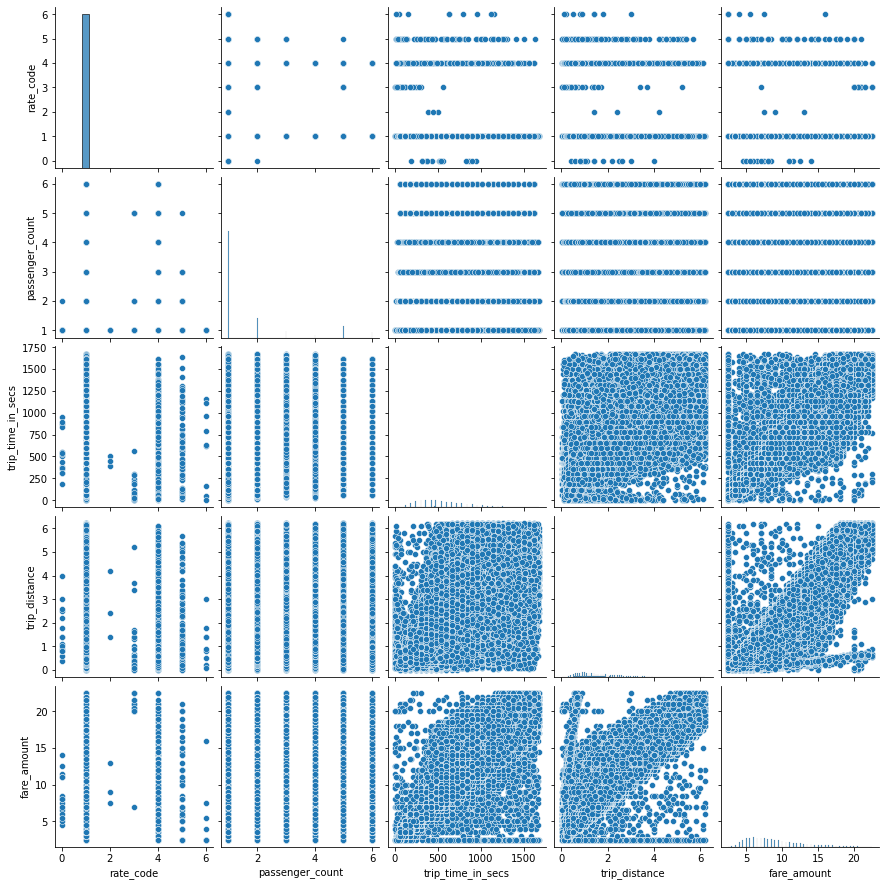

In [235]:
sns.pairplot(new_df)

## 시각화

In [30]:
df = new_df.copy()
df.head()

,vendor_id,rate_code,passenger_count,trip_time_in_secs,trip_distance,payment_type,fare_amount
0,CMT,1,1,1271,3.8,CRD,17.5
1,CMT,1,1,474,1.5,CRD,8.0
2,CMT,1,1,637,1.4,CRD,8.5
3,CMT,1,1,181,0.6,CSH,4.5
4,CMT,1,1,661,1.1,CRD,8.5


### 택시 승객 수

<AxesSubplot:xlabel='passenger_count', ylabel='count'>

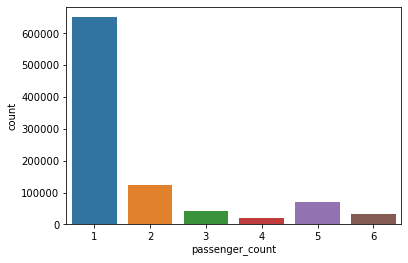

In [31]:
sns.countplot(x = "passenger_count", data = df)

In [32]:
values = new_df['passenger_count'].value_counts()
labels = values.index

Text(0.5, 1.0, 'passenger_count')

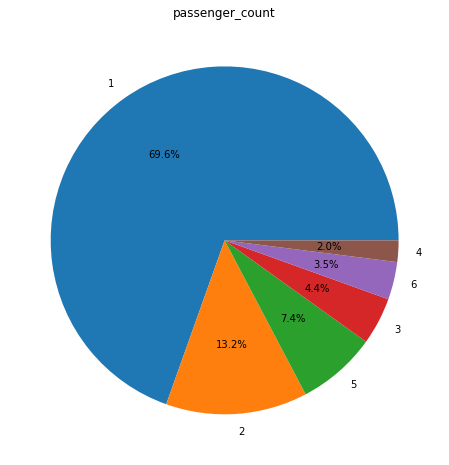

In [33]:
plt.figure(figsize = (8, 8))
plt.pie(values, labels = labels, autopct = '%.1f%%')
plt.title('passenger_count')

### 택시 공급업체

<AxesSubplot:xlabel='vendor_id', ylabel='count'>

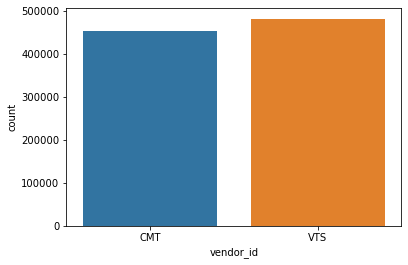

In [34]:
# 택시 공급업체 id 히스토그램
sns.countplot(x = "vendor_id", data = df)

In [35]:
values = new_df['vendor_id'].value_counts()
labels = values.index

Text(0.5, 1.0, 'vendor_id')

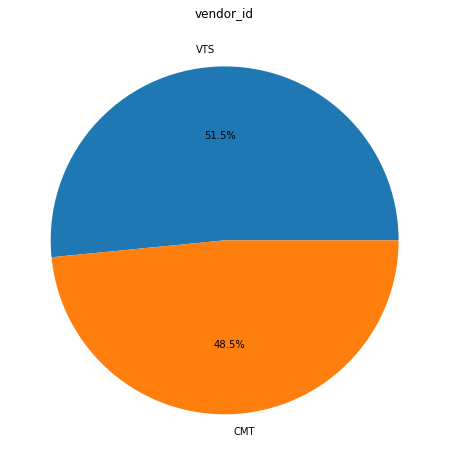

In [36]:
plt.figure(figsize = (8, 8))
plt.pie(values, labels = labels, autopct = '%.1f%%')
plt.title('vendor_id')

### 택시 결제타입

<AxesSubplot:xlabel='payment_type', ylabel='count'>

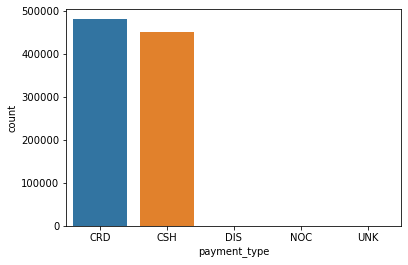

In [37]:
# 택시 결제타입 히스토그램
sns.countplot(x = "payment_type", data = df)

In [38]:
values = new_df['payment_type'].value_counts()
labels = values.index

Text(0.5, 1.0, 'payment_type')

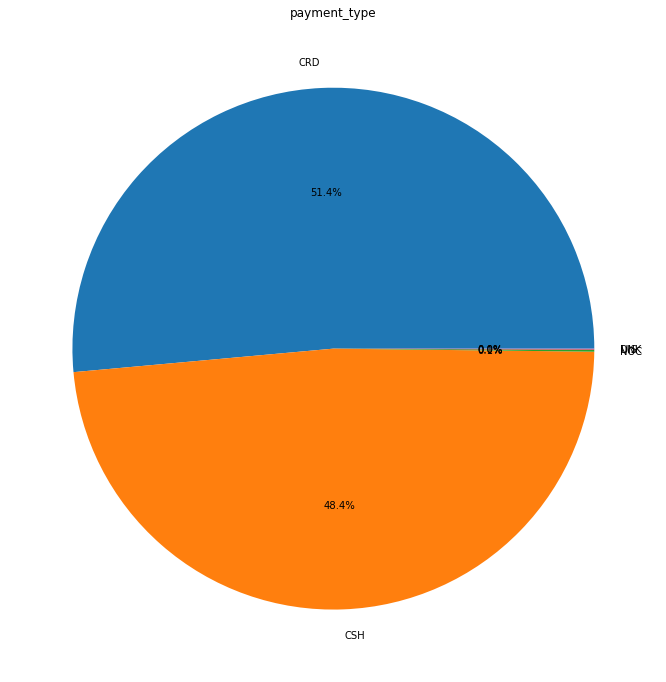

In [39]:
plt.figure(figsize = (12, 12))
plt.pie(values, labels = labels, autopct = '%.1f%%')
plt.title('payment_type')

In [40]:
df.rate_code.value_counts()

1    933896
4       938
5        84
3        35
0        15
6         9
2         3
Name: rate_code, dtype: int64

<AxesSubplot:xlabel='rate_code', ylabel='count'>

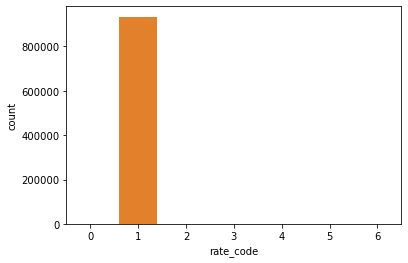

In [41]:
# 택시 이동요금 유형 히스토그램
sns.countplot(x = "rate_code", data = df)

<AxesSubplot:xlabel='trip_distance', ylabel='Density'>

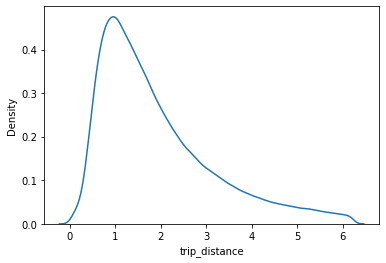

In [42]:
sns.kdeplot(x = "trip_distance", data = df)

<AxesSubplot:xlabel='trip_time_in_secs', ylabel='Density'>

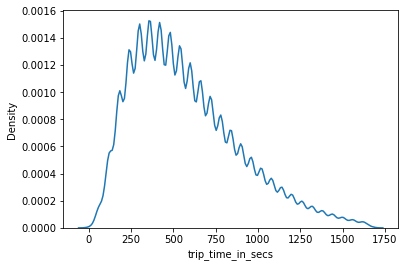

In [43]:
sns.kdeplot(x = "trip_time_in_secs", data = df)

<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

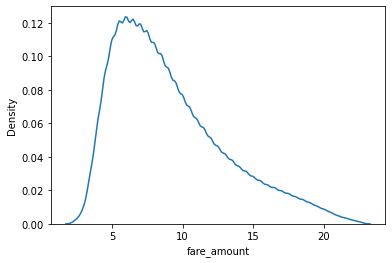

In [44]:
sns.kdeplot(x = "fare_amount", data = df)

In [45]:
# 이동을 완료하기 전에 이동 요금을 예측
# 이동 요금은 이동 시간, 이동 거리와 상관성이 있을 것이라고 가설을 세움. 

# 이동 시간과 요금과의 관계
# 이동 거리와 요금과의 관계
# 이동 승객 수와 요금과의 관계

In [46]:
# 피어슨 상관계수를 통한 상관 분석
# 이동 요금과 이동 시간, 이동 이동 거리의 상관 계수가 각각 0.8, 0.87로 높음. => 가설이 맞다.
df.corr(method = "pearson")

,rate_code,passenger_count,trip_time_in_secs,trip_distance,fare_amount
rate_code,1.000000,-0.005718,-0.002112,-0.001932,0.000537
passenger_count,-0.005718,1.000000,0.009806,0.014614,0.008187
trip_time_in_secs,-0.002112,0.009806,1.000000,0.758154,0.920757
trip_distance,-0.001932,0.014614,0.758154,1.000000,0.937817
fare_amount,0.000537,0.008187,0.920757,0.937817,1.000000


<AxesSubplot:>

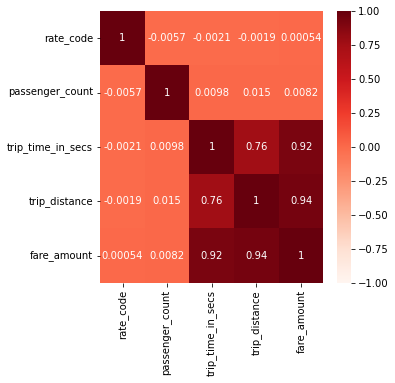

In [47]:
# 상관성을 한 눈에 파악하기 쉽도록 heatmap을 작성
# 상관성이 클수록 색이 짙다.
plt.rcParams["figure.figsize"] = (5,5)
sns.heatmap(df.corr(),
           annot = True,
           cmap = "Reds",
           vmin = - 1,
           vmax = 1)

In [18]:
import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__)

2.9.1


In [19]:
df = new_df.copy()

In [20]:
df.head()

,vendor_id,rate_code,passenger_count,trip_time_in_secs,trip_distance,payment_type,fare_amount
0,CMT,1,1,1271,3.8,CRD,17.5
1,CMT,1,1,474,1.5,CRD,8.0
2,CMT,1,1,637,1.4,CRD,8.5
3,CMT,1,1,181,0.6,CSH,4.5
4,CMT,1,1,661,1.1,CRD,8.5


## one-hot encoding
## 범주형: vendor_id, rate_code, payment_type

In [21]:
df.vendor_id.unique()

array(['CMT', 'VTS'], dtype=object)

In [22]:
vendor_id = df.pop('vendor_id')

In [23]:
df['CMT'] = (vendor_id == 'CMT') * 1.0
df['VTS'] = (vendor_id == 'VTS') * 1.0
df

,rate_code,passenger_count,trip_time_in_secs,trip_distance,payment_type,fare_amount,CMT,VTS
0,1,1,1271,3.80,CRD,17.5,1.0,0.0
1,1,1,474,1.50,CRD,8.0,1.0,0.0
2,1,1,637,1.40,CRD,8.5,1.0,0.0
3,1,1,181,0.60,CSH,4.5,1.0,0.0
4,1,1,661,1.10,CRD,8.5,1.0,0.0
...,...,...,...,...,...,...,...,...
934975,1,1,120,0.83,CSH,4.5,0.0,1.0
934976,1,1,780,2.96,CRD,11.5,0.0,1.0
934977,1,1,300,0.97,CSH,5.5,0.0,1.0
934978,1,1,900,5.94,CSH,19.0,0.0,1.0


In [24]:
df.rate_code.unique()

array([1, 4, 3, 5, 0, 2, 6], dtype=int64)

In [25]:
rate_code = df.pop('rate_code')

In [26]:
df['rate_code_0'] = (rate_code == 0) * 1.0
df['rate_code_1'] = (rate_code == 1) * 1.0
df['rate_code_2'] = (rate_code == 2) * 1.0
df['rate_code_3'] = (rate_code == 3) * 1.0
df['rate_code_4'] = (rate_code == 4) * 1.0
df['rate_code_5'] = (rate_code == 5) * 1.0
df['rate_code_6'] = (rate_code == 6) * 1.0
df
# rate_code

,passenger_count,trip_time_in_secs,trip_distance,payment_type,fare_amount,CMT,VTS,rate_code_0,rate_code_1,rate_code_2,rate_code_3,rate_code_4,rate_code_5,rate_code_6
0,1,1271,3.80,CRD,17.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,474,1.50,CRD,8.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,637,1.40,CRD,8.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1,181,0.60,CSH,4.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1,661,1.10,CRD,8.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934975,1,120,0.83,CSH,4.5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
934976,1,780,2.96,CRD,11.5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
934977,1,300,0.97,CSH,5.5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
934978,1,900,5.94,CSH,19.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [27]:
df.payment_type.unique()

array(['CRD', 'CSH', 'DIS', 'NOC', 'UNK'], dtype=object)

In [28]:
payment_type = df.pop('payment_type')

In [29]:
df['CRD'] = (payment_type == 'CRD') * 1.0
df['CSH'] = (payment_type == 'CSH') * 1.0
df['DIS'] = (payment_type == 'DIS') * 1.0
df['NOC'] = (payment_type == 'NOC') * 1.0
df['UNK'] = (payment_type == 'UNK') * 1.0
df
# rate_code

,passenger_count,trip_time_in_secs,trip_distance,fare_amount,CMT,VTS,rate_code_0,rate_code_1,rate_code_2,rate_code_3,rate_code_4,rate_code_5,rate_code_6,CRD,CSH,DIS,NOC,UNK
0,1,1271,3.80,17.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,474,1.50,8.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,637,1.40,8.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,181,0.60,4.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,661,1.10,8.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934975,1,120,0.83,4.5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
934976,1,780,2.96,11.5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
934977,1,300,0.97,5.5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
934978,1,900,5.94,19.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## train, test 데이터 분리

In [30]:
train_dataset = df.sample(frac = 0.8, random_state = 0)
test_dataset = df.drop(train_dataset.index)

### train: 747,984, test: 186,996

In [31]:
print(train_dataset.shape)
print(test_dataset.shape)

(747984, 18)
(186996, 18)


### train, test data 저장

In [32]:
train_dataset.to_csv('taxi_train.csv', index = False)
test_dataset.to_csv('taxi_test.csv', index = False)

### train, test data 로드

In [33]:
train_dataset = pd.read_csv('taxi_train.csv')
test_dataset = pd.read_csv('taxi_test.csv')

In [34]:
y_train = train_dataset.pop('fare_amount')
y_test = test_dataset.pop('fare_amount')

In [35]:
y_train

0         13.5
1          6.0
2         12.0
3         10.5
4          8.5
          ... 
747979    10.0
747980     3.5
747981     6.5
747982     5.5
747983     5.5
Name: fare_amount, Length: 747984, dtype: float64

## Min-Max scailing

In [36]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

In [37]:
minmax_scaler = MinMaxScaler()
x_train = minmax_scaler.fit_transform(train_dataset)
x_train

array([[0.        , 0.5447494 , 0.49758454, ..., 0.        , 0.        ,
        0.        ],
       [0.8       , 0.17840095, 0.16425121, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.54057279, 0.4331723 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.2       , 0.17840095, 0.22705314, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.14260143, 0.16425121, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.21420048, 0.14492754, ..., 0.        , 0.        ,
        0.        ]])

In [38]:
x_test = minmax_scaler.fit_transform(test_dataset)
x_test

array([[0.        , 0.28221957, 0.23993559, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.39379475, 0.17552335, ..., 0.        , 0.        ,
        0.        ],
       [0.4       , 0.22076372, 0.09500805, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.2       , 0.35739857, 0.27697262, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.50059666, 0.88244767, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.17840095, 0.15458937, ..., 0.        , 0.        ,
        0.        ]])

In [39]:
x_train.shape

(747984, 17)

### Sequential

In [40]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation = 'relu', input_shape=[x_train.shape[1]]), 
        layers.Dense(64, activation = 'relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss = 'mse',
                 optimizer = optimizer,
                 metrics = ['mae', 'mse'])
    return model

In [41]:
model = build_model()

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1152      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________


### 모델 훈련

In [43]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [ ]:
EPOCHS = 30
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
  x_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot(), early_stop])


......

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
hist['rmse'] = np.sqrt(hist['mse'])
hist.tail()

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

In [ ]:
loss, mae, mse = model.evaluate(x_test, y_test, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

### 예측

In [ ]:
test_predictions = model.predict(x_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
EPOCHS = 100
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
  x_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
hist['rmse'] = np.sqrt(hist['mse'])
hist.tail()

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

In [ ]:
loss, mae, mse = model.evaluate(x_test, y_test, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

### 예측

In [ ]:
test_predictions = model.predict(x_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [94]:
test_predictions

array([ 7.763256,  8.430844,  5.749058, ...,  8.793322, 17.771317,
        5.681179], dtype=float32)

In [154]:
y_test

0          8.0
1          8.5
2          6.0
3          8.5
4          9.0
          ... 
186991     8.5
186992    20.0
186993     8.0
186994    17.5
186995     5.5
Name: fare_amount, Length: 186996, dtype: float64

In [155]:
temp_1 = pd.DataFrame({
    'pred': test_predictions,
    'actual': y_test
})

In [159]:
temp_1 = temp_1[temp_1['actual'] < 5]

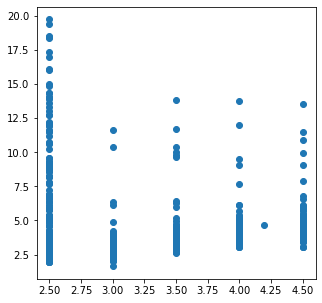

In [161]:
plt.scatter(temp_1['actual'], temp_1['pred'])

In [162]:
temp_1[temp_1['actual'] == 2.5]

,pred,actual
436,2.695063,2.5
1043,2.558353,2.5
2364,2.739679,2.5
3901,2.802104,2.5
4041,2.118779,2.5
...,...,...
183541,2.915449,2.5
184894,2.377548,2.5
184917,2.563036,2.5
184964,2.345086,2.5


### 오차의 분포

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

### 이동시간 컬럼을 제외하면 결과가 어떻게 될지?

In [ ]:
train_dataset_2 = train_dataset.drop(labels = 'trip_time_in_secs', axis = 1)

In [ ]:
test_dataset_2 = test_dataset.drop(labels = 'trip_time_in_secs', axis = 1)

In [ ]:
train_dataset_2

In [ ]:
test_dataset_2

In [ ]:
minmax_scaler = MinMaxScaler()
x_train_2 = minmax_scaler.fit_transform(train_dataset_2)
x_train_2

In [ ]:
x_test_2 = minmax_scaler.fit_transform(test_dataset_2)
x_test_2

In [ ]:
x_train_2.shape

In [ ]:
x_test_2.shape

In [ ]:
EPOCHS = 30
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
  x_train_2, y_train_2,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot(), early_stop])

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
hist['rmse'] = np.sqrt(hist['mse'])
hist.tail()

In [ ]:
plot_history(history)

In [ ]:
loss, mae, mse = model.evaluate(x_test_2, y_test_2, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

### 예측

In [ ]:
test_predictions = model.predict(x_test_2).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

### 오차의 분포

In [ ]:
error = test_predictions - y_test_2
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

### => 이동시간을 뺐더니 모델의 예측 정확도가 더 떨어졌다.

### 신경망을 더 깊게 쌓아본다.

In [ ]:
def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation = 'relu', input_shape=[x_train.shape[1]]), 
        layers.Dense(64, activation = 'relu'),
        layers.Dense(32, activation = 'relu'),
        layers.Dense(16, activation = 'relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss = 'mse',
                 optimizer = optimizer,
                 metrics = ['mae', 'mse'])
    return model

In [ ]:
model = build_model()

In [ ]:
EPOCHS = 30
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
  x_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot(), early_stop])

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
hist['rmse'] = np.sqrt(hist['mse'])
hist.tail()

In [ ]:
loss, mae, mse = model.evaluate(x_test, y_test, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

### 예측

In [ ]:
test_predictions = model.predict(x_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

### 오차의 분포

In [ ]:
error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

## 앙상블

In [55]:
# sklearn 평가지표 활용
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

# prediction plot
def plot_predictions(name_, actual, pred):
    df = pd.DataFrame({'actual': test_labels, 'prediction': pred})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

# evaluation plot
def mse_eval(name_, actual, pred):
    global predictions
    global colors

    plot_predictions(name_, actual, pred)

    mse = mean_squared_error(actual, pred)
    my_predictions[name_] = mse

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['mse'])
    
    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('MSE Error', fontsize=18)
    plt.xlim(min_, max_)
    
    plt.show()

# remove model
def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True


# coefficients visulization
def plot_coef(columns, coef):
    coef_df = pd.DataFrame(list(zip(columns, coef)))
    coef_df.columns=['feature', 'coef']
    coef_df = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.barh(np.arange(len(coef_df)), coef_df['coef'])
    idx = np.arange(len(coef_df))
    ax.set_yticks(idx)
    ax.set_yticklabels(coef_df['feature'])
    fig.tight_layout()
    plt.show()

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

### Linear Regression

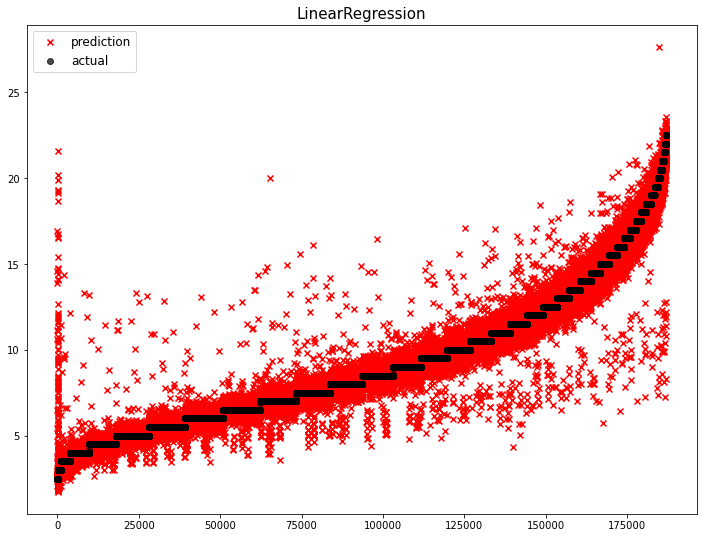

              model       mse
0  LinearRegression  0.260206


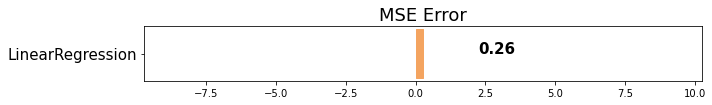

In [62]:
linear_reg = LinearRegression(n_jobs=-1)
linear_reg.fit(train, train_labels)
linear_pred = linear_reg.predict(test)
mse_eval('LinearRegression', test_labels, linear_pred)

### Ridge

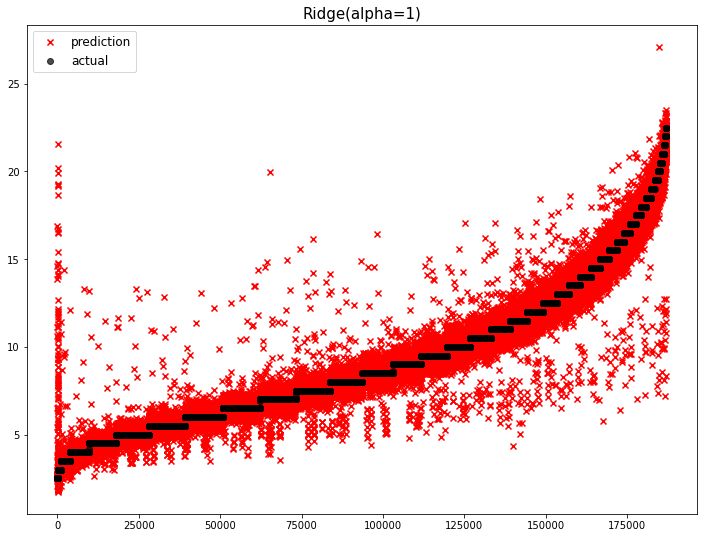

              model       mse
0    Ridge(alpha=1)  0.260273
1  LinearRegression  0.260206


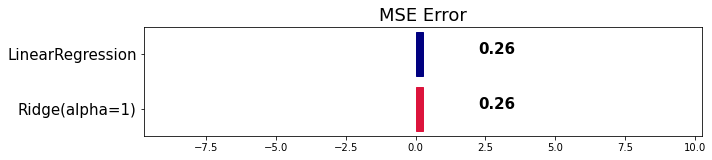

In [64]:
ridge = Ridge(alpha=1)
ridge.fit(train, train_labels)
ridge_pred = ridge.predict(test)
mse_eval('Ridge(alpha=1)', test_labels, ridge_pred)

### LASSO

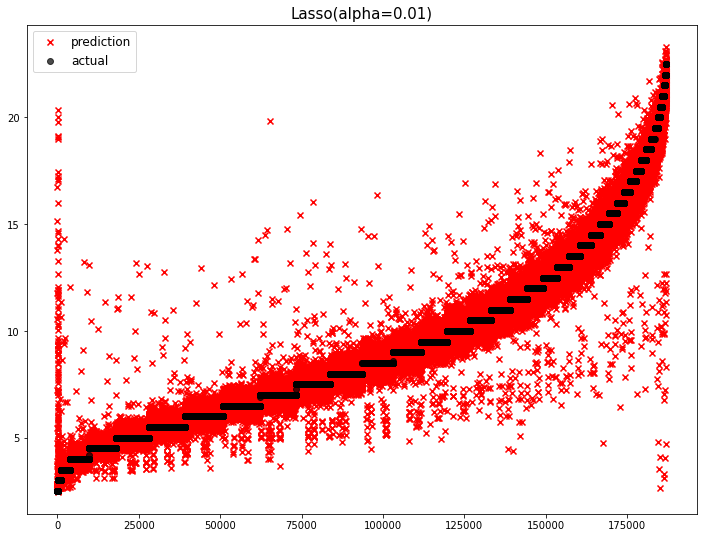

               model       mse
0  Lasso(alpha=0.01)  0.278063
1     Ridge(alpha=1)  0.260273
2   LinearRegression  0.260206


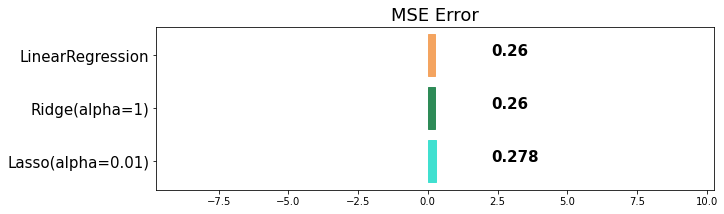

In [65]:
lasso = Lasso(alpha=0.01)
lasso.fit(train, train_labels)
lasso_pred = lasso.predict(test)
mse_eval('Lasso(alpha=0.01)', test_labels, lasso_pred)

5844/5844 [==============================] - 3s 536us/step


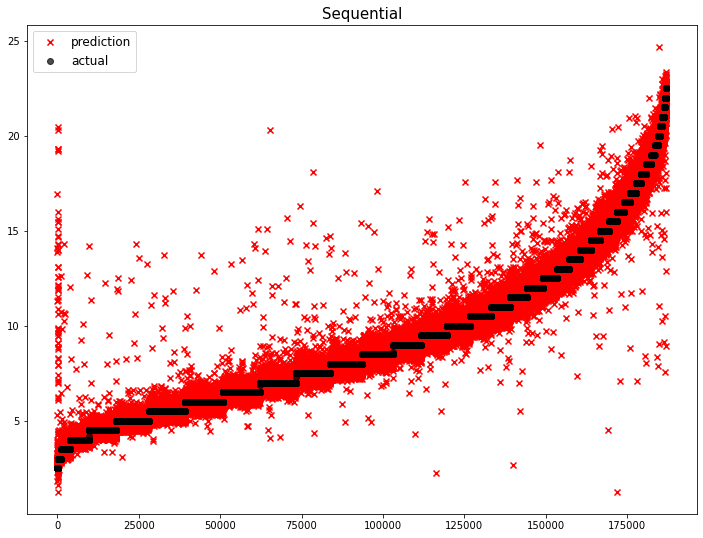

               model       mse
0  Lasso(alpha=0.01)  0.278063
1     Ridge(alpha=1)  0.260273
2   LinearRegression  0.260206
3         Sequential  0.194863


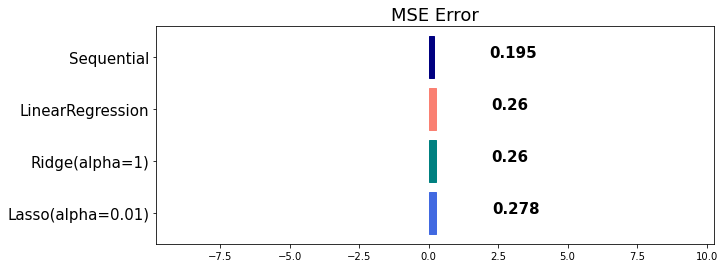

In [68]:
sequential_pred = model.predict(test).flatten()
mse_eval('Sequential', test_labels, sequential_pred)